### Marketing Analytics Research Plan
- Analyzing data for research 
    - Who is more likely to spend more in a black Friday sale?
        - Men or Women.
        - Married or Un Married
        - Old Residents or new residents 
    - Which products are more likely to be sold in a sale like black Friday?
    - Which products are common among men and which among women?
- Marketing Recommendations
    - Using Apriori (Market Basket Analysis) find which products were frequently bought together
    - Create Marketing coupon campaign
    - What are our customer segments?
    - Suggest products based on age.
    - Suggest products based on city category.
    - Suggest products based on gender.
    - Suggest products based on occupation.
    - Model Spending (Purchase) based on factors

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
import numpy as np

In [2]:
# Configure visualizations
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8, 6
pd.set_option('display.max_columns', 5000)

In [3]:
# Define distribution helper function for later on
def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue = target, aspect = 4, row = row, col = col)
    facet.map(sns.kdeplot, var, shade = True)
    facet.set(xlim = (0, df[var].max()))
    facet.add_legend()

In [4]:
# Import the dataset
df = pd.read_csv("C:\\Users\\EISELJA\\Desktop\\Kaggle-master\\datasets\BlackFriday.csv")

In [5]:
print("The shape of our dataframe is {}".format(df.shape[0]) + " rows, and {}".format(df.shape[1]) + " columns")

The shape of our dataframe is 537577 rows, and 12 columns


In [6]:
# Check the top 5 rows
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


### Feature definition
- User_ID: User ID
- Product_ID: Product ID
- Gender: Sex of User
- Age: Age in bins
- Occupation: Occupation
- City_Category: Category of the City (A,B,c
- Stay_In_Current_City_Years: Number of years stay in current city
- Marital_Status: Marital Status (0~Single, 1~Married)
- Product_Category_1: Product Category
- Product_Category_2: Product may belongs to other category also
- Product_Category_3: Product may belongs to other category also
- Purchase: Purchase amount in dollars

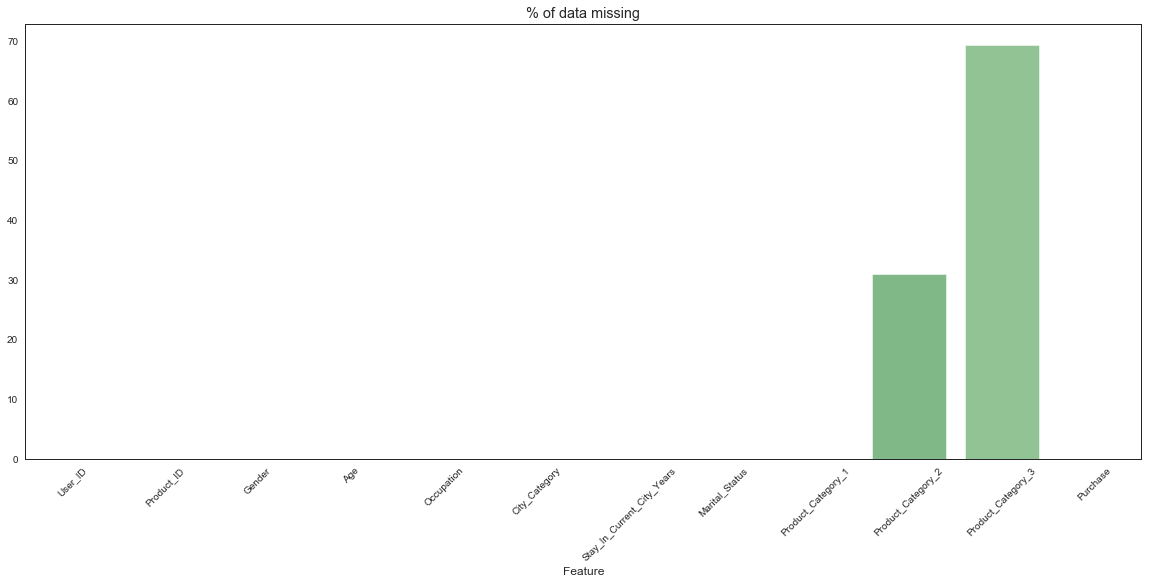

In [7]:
# Check for missing values
plt.figure(figsize=(20,8))
plt.title('% of data missing')
plt.xlabel("Feature")
plt.xticks(rotation = 45)
sns.barplot(x = df.columns, palette="Greens_d", y = df.isnull().sum()/537577 *100)

## We can see there is a lot of data missing from features Product_Category_2 (31%) and Product_Category_3 (69%)
### After meeting with the business unit we decided to drop the product category features as our target variable is to use multinomial logit model to predict what is the probability of purchase for a product ID based on demographic data

In [8]:
# Drop Product Category Columns
df.drop(columns = ['Product_Category_1','Product_Category_2','Product_Category_3'], inplace = True)

In [9]:
# Recheck dataframe for missing values
df.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Purchase                      0
dtype: int64

In [10]:
print("The new shape of our dataframe is {}".format(df.shape[0]) + " rows, and {}".format(df.shape[1]) + " columns")

The new shape of our dataframe is 537577 rows, and 9 columns


### Our dataset still has 537577 rows before and after dropping the 3 product category features.

In [11]:
df['Purchase'] = df['Purchase'].astype(dtype = 'float')
df.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Purchase                      float64
dtype: object

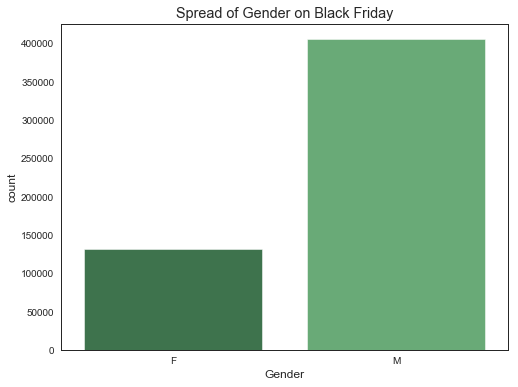

In [12]:
# Majority of customers were male
plt.title("Spread of Gender on Black Friday")
sns.countplot(df['Gender'], palette="Greens_d")

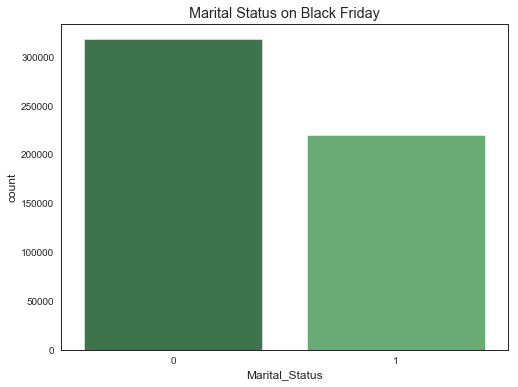

In [13]:
# Majority of customers were single
plt.title("Marital Status on Black Friday")
sns.countplot(df['Marital_Status'], palette="Greens_d")

Text(0.5,1,'Purchase behavior based on Gender')

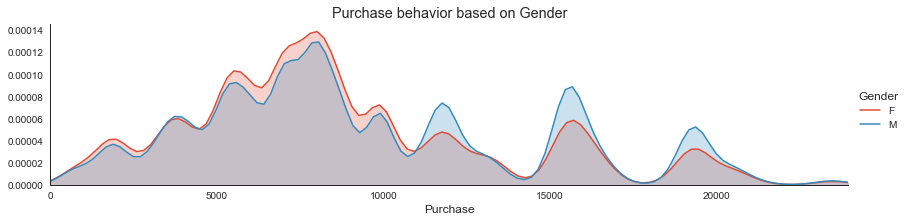

In [14]:
# Compare Male vs Female Spending Distributions
plot_distribution(df, var = 'Purchase', target = 'Gender')
plt.title('Purchase behavior based on Gender')

Text(0.5,1,'Boxplot of Marital Status and Gender Purchase Behavior')

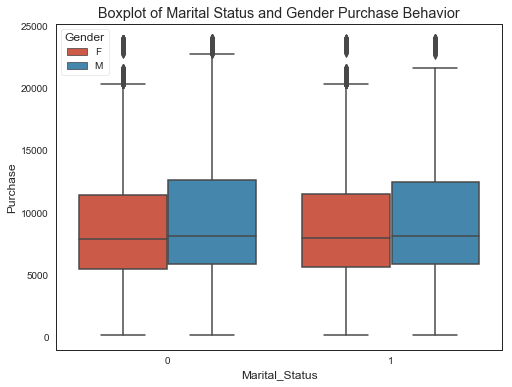

In [15]:
sns.boxplot(x="Marital_Status", y="Purchase", hue="Gender", data=df)
plt.title("Boxplot of Marital Status and Gender Purchase Behavior")

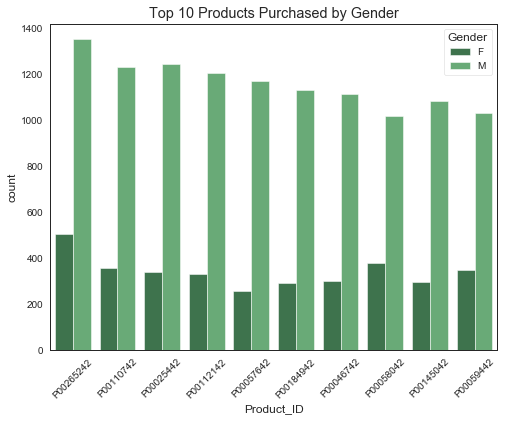

In [17]:
plt.title("Top 10 Products Purchased by Gender")
plt.xticks(rotation = 45)
sns.countplot(data = df, x = 'Product_ID', hue = 'Gender', palette="Greens_d", order=df['Product_ID'].value_counts().iloc[:10].index)

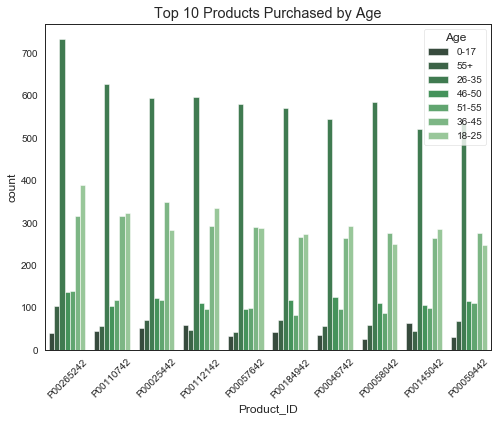

In [16]:
plt.title("Top 10 Products Purchased by Age")
plt.xticks(rotation = 45)
sns.countplot(data = df, x = 'Product_ID', hue = 'Age', palette="Greens_d", order=df['Product_ID'].value_counts().iloc[:10].index)

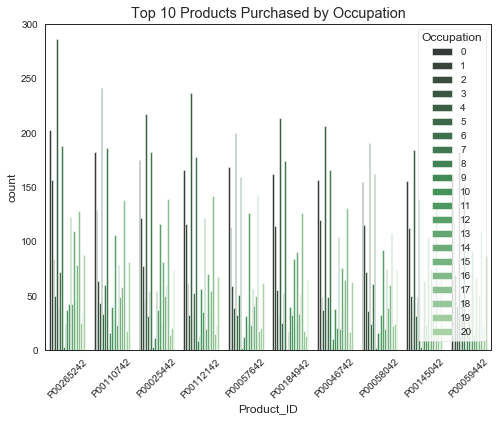

In [18]:
plt.title("Top 10 Products Purchased by Occupation")
plt.xticks(rotation = 45)
sns.countplot(data = df, x = 'Product_ID', hue = 'Occupation', palette="Greens_d", order=df['Product_ID'].value_counts().iloc[:10].index)

In [19]:
# Create dummie variables for Gender
gender = pd.get_dummies(df['Gender'])

# Concatenate dummie variables back to the original dataframe
df = pd.concat([df, gender], axis = 1)

# Drop the previous feature for "Gender"
df.drop(columns = 'Gender', inplace = True)

# Check the head of the DataFrame and verify
df.head()

,User_ID,Product_ID,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase,F,M
0,1000001,P00069042,0-17,10,A,2,0,8370.0,1,0
1,1000001,P00248942,0-17,10,A,2,0,15200.0,1,0
2,1000001,P00087842,0-17,10,A,2,0,1422.0,1,0
3,1000001,P00085442,0-17,10,A,2,0,1057.0,1,0
4,1000002,P00285442,55+,16,C,4+,0,7969.0,0,1


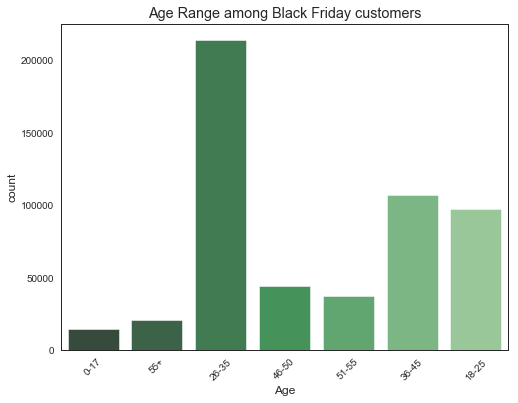

In [21]:
# Majority of consumers fall into 26-35 range
plt.title("Age Range among Black Friday customers")
plt.xticks(rotation = 45)
sns.countplot(data = df, x = 'Age', palette = 'Greens_d')

Text(0.5,1,'Purchase behavior based on Age Bins')

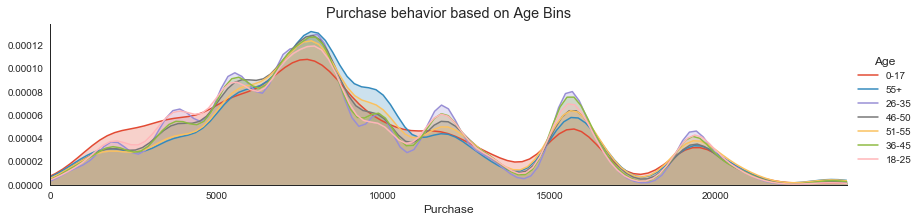

In [20]:
# Compare Age Range Spending Disitrbutions
plot_distribution(df, var = 'Purchase', target = 'Age')
plt.title("Purchase behavior based on Age Bins")

In [22]:
# Create Dummie variables for the Age feature
age = pd.get_dummies(df['Age'], prefix = "Age")

# Concatenate the dummie variables ot the orignal dataframe
df = pd.concat([df, age], axis =1)
df.drop(columns = 'Age', inplace = True)
df.head()

,User_ID,Product_ID,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase,F,M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+
0,1000001,P00069042,10,A,2,0,8370.0,1,0,1,0,0,0,0,0,0
1,1000001,P00248942,10,A,2,0,15200.0,1,0,1,0,0,0,0,0,0
2,1000001,P00087842,10,A,2,0,1422.0,1,0,1,0,0,0,0,0,0
3,1000001,P00085442,10,A,2,0,1057.0,1,0,1,0,0,0,0,0,0
4,1000002,P00285442,16,C,4+,0,7969.0,0,1,0,0,0,0,0,0,1


Text(0.5,1,'Purchase Behavior based on Marital Status')

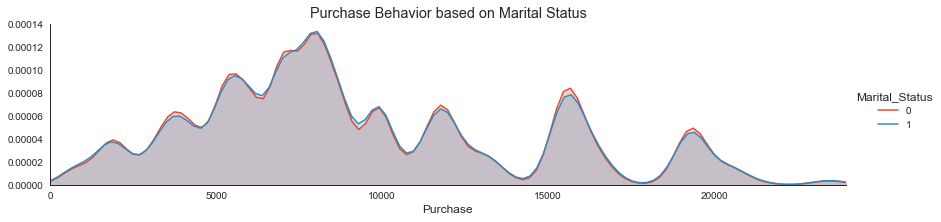

In [23]:
plot_distribution(df = df, var = 'Purchase', target = 'Marital_Status')
plt.title("Purchase Behavior based on Marital Status")

Text(0.5,1,'Purchase behavior based on duration of residence')

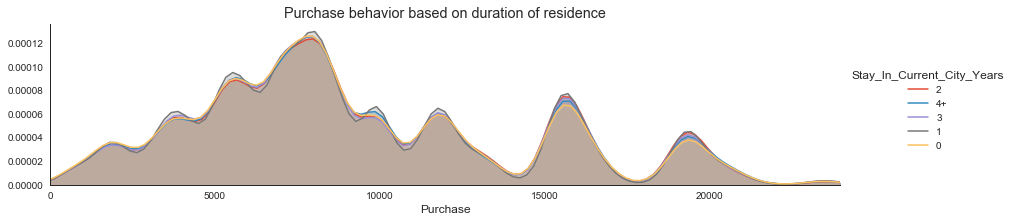

In [24]:
plot_distribution(df, var = 'Purchase', target = 'Stay_In_Current_City_Years')
plt.title("Purchase behavior based on duration of residence")

Text(0.5,1,'Purchase behavior based on Occupation')

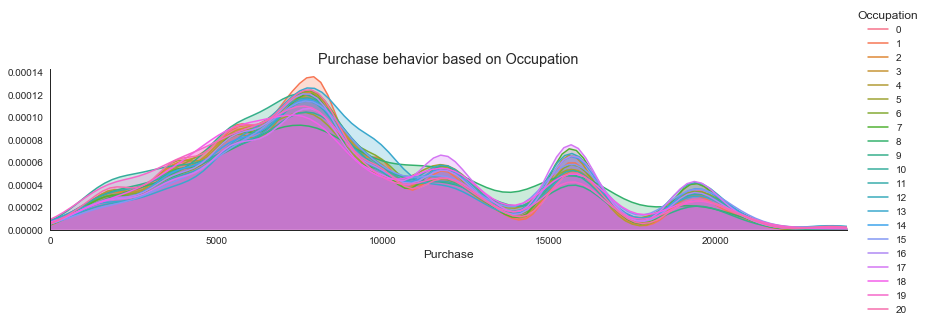

In [25]:
plot_distribution(df, var = 'Purchase', target ='Occupation')
plt.title("Purchase behavior based on Occupation")

In [26]:
df.head()

,User_ID,Product_ID,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase,F,M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+
0,1000001,P00069042,10,A,2,0,8370.0,1,0,1,0,0,0,0,0,0
1,1000001,P00248942,10,A,2,0,15200.0,1,0,1,0,0,0,0,0,0
2,1000001,P00087842,10,A,2,0,1422.0,1,0,1,0,0,0,0,0,0
3,1000001,P00085442,10,A,2,0,1057.0,1,0,1,0,0,0,0,0,0
4,1000002,P00285442,16,C,4+,0,7969.0,0,1,0,0,0,0,0,0,1


In [28]:
# Drop Product_ID columns
df.drop(columns = ['Product_ID'], inplace = True)
df.head()

,User_ID,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase,F,M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+
0,1000001,10,0,2,0,8370.0,1,0,1,0,0,0,0,0,0
1,1000001,10,0,2,0,15200.0,1,0,1,0,0,0,0,0,0
2,1000001,10,0,2,0,1422.0,1,0,1,0,0,0,0,0,0
3,1000001,10,0,2,0,1057.0,1,0,1,0,0,0,0,0,0
4,1000002,16,2,4,0,7969.0,0,1,0,0,0,0,0,0,1


In [27]:
# Encode/transform categorical variables 'City_Category', 'Stay_In_Current_City_Years' and 'Occupation'
le = LabelEncoder()
df['City_Category'] = le.fit_transform(df['City_Category'])
df['Stay_In_Current_City_Years'] = le.fit_transform(df['Stay_In_Current_City_Years'])
df['Occupation'] = le.fit_transform(df['Occupation'])
df.head()

,User_ID,Product_ID,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase,F,M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+
0,1000001,P00069042,10,0,2,0,8370.0,1,0,1,0,0,0,0,0,0
1,1000001,P00248942,10,0,2,0,15200.0,1,0,1,0,0,0,0,0,0
2,1000001,P00087842,10,0,2,0,1422.0,1,0,1,0,0,0,0,0,0
3,1000001,P00085442,10,0,2,0,1057.0,1,0,1,0,0,0,0,0,0
4,1000002,P00285442,16,2,4,0,7969.0,0,1,0,0,0,0,0,0,1


In [29]:
# Group our dataset by purchase
df = df.groupby(['User_ID', 'Occupation','City_Category','Stay_In_Current_City_Years','Marital_Status','F','M','Age_0-17','Age_18-25','Age_26-35','Age_36-45','Age_46-50','Age_51-55','Age_55+'])['Purchase'].sum().reset_index()

In [30]:
df.head()

,User_ID,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,F,M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Purchase
0,1000001,10,0,2,0,1,0,1,0,0,0,0,0,0,333481.0
1,1000002,16,2,4,0,0,1,0,0,0,0,0,0,1,810353.0
2,1000003,15,0,3,0,0,1,0,0,1,0,0,0,0,341635.0
3,1000004,7,1,2,1,0,1,0,0,0,0,1,0,0,205987.0
4,1000005,20,0,1,1,0,1,0,0,1,0,0,0,0,821001.0


### Modeling our data

In [31]:
# Split our dataset into X and y
#df.columns
X = df[['Occupation','City_Category','Stay_In_Current_City_Years','Marital_Status','F','M','Age_0-17','Age_18-25','Age_26-35','Age_36-45','Age_46-50','Age_51-55','Age_55+']]
y = df['Purchase']

In [32]:
# Convert X and y to arrays
X = np.array(X)
y = np.array(y)

In [33]:
# Instantiate a standard scaler
sc = StandardScaler()

In [34]:
# Normalize our dataset and split into X
X = sc.fit_transform(X)
#y = sc.fit_transform(y)

In [35]:
# Split training dataset into X_train and y_train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Linear Regression

In [36]:
lr = LinearRegression()

In [37]:
# Fit our Logistic Regression model to the training dataset
lin_reg = lr.fit(X_train, y_train)
print("The coefficients of our Linear Regression model are " + str(list(lin_reg.coef_)))

The coefficients of our Linear Regression model are [-11292.340761179234, -311055.38462249533, -2527.860265873783, -1217.1845069425453, -2.203421562123075e+16, -2.2034215621129692e+16, -5.888648664234508e+16, -1.2022186495437026e+17, -1.4863735381256918e+17, -1.2432869569693237e+17, -8.933274116823814e+16, -8.54185462505614e+16, -7.587219912084547e+16]


In [39]:
print("The intercept of our Linear Regression model is " + str(lin_reg.intercept_))

The intercept of our Linear Regression model is 847296.1239388795


In [38]:
print("The accuracy of our Linear Regression model is " + str(lin_reg.score(X_train, y_train)*100) + "%")

The accuracy of our Linear Regression model is 13.89018673573844%


### Decision Tree Regressor

In [41]:
# Fitting Decision Tree Classification to the Training set
from sklearn.tree import DecisionTreeRegressor
classifier = DecisionTreeRegressor(criterion = 'mse', random_state = 0)
classifier.fit(X_train, y_train)
print("The accuracy of our Decision Tree model is " + str(classifier.score(X_train, y_train)*100) + "%")

The accuracy of our Decision Tree model is 60.892987073396974%


In [42]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

### Logistic Regression

In [43]:
# Logistic Regression Model
log_reg = LogisticRegression(random_state = 0)
log_reg.fit(X_train, y_train)
print("The accuracy of our Logistic Regrescion model is " + str(log_reg.score(X_train, y_train)*100) + "%")

The accuracy of our Logistic Regrescion model is 5.751273344651953%


## Association Rule Mining (Apriori~ Market Basket Analysis) 

### Support
- Support refers to the default popularity of an item and can be calculated by finding number of transactions containing a particular item divided by total number of transactions 
    - *This item was bought % of the time*
    
### Confidence
- Confidence refers to the likelihood that an item B is also bought if item A is bought. It can be calculated by finding the number of transactions where A and B are bought together, divided by total number of transactions where A is bought. 
    - *This item was bought % of the time with item A*
    
### Lift
- Is the ratio of the observed support to that expected if the two rules were independent (see wikipedia). The basic rule of thumb is that a lift value close to 1 means the rules were completely independent. Lift values > 1 are generally more “interesting” and could be indicative of a useful rule pattern.

In [44]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
basket = pd.read_csv("C:\\Users\\EISELJA\\Desktop\\Kaggle-master\\datasets\\BlackFriday.csv")
basket.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [45]:
# Group our dataset by User_ID
basket = (basket.groupby(['User_ID','Product_ID'])['Product_ID'].count().unstack().reset_index().set_index('User_ID'))

In [46]:
# Create a binary "basket" for each user_id
basket.fillna(0, inplace = True)
basket.head()

Product_ID  P00000142  P00000242  P00000342  P00000442  P00000542  P00000642  \
User_ID                                                                        
1000001           1.0        0.0        0.0        0.0        0.0        0.0   
1000002           0.0        0.0        0.0        0.0        0.0        0.0   
1000003           0.0        0.0        0.0        0.0        0.0        0.0   
1000004           0.0        0.0        0.0        0.0        0.0        0.0   
1000005           0.0        0.0        0.0        0.0        0.0        0.0   

Product_ID  P00000742  P00000842  P00000942  P00001042  P00001142  P00001242  \
User_ID                                                                        
1000001           0.0        0.0        0.0        0.0        0.0        0.0   
1000002           0.0        0.0        0.0        0.0        0.0        0.0   
1000003           0.0        0.0        0.0        0.0        0.0        0.0   
1000004           0.0        0.0        0.0        0.0        0.0        0.0   
1000005           0.0        0.0        0.0        0.0        0.0        0.0   

Product_ID  P00001342  P00001442  P00001542  P00001642  P00001742  P00001842  \
User_ID                                                                        
1000001           0.0        0.0        0.0        0.0        0.0        0.0   
1000002           0.0        0.0        0.0        0.0        0.0        0.0   
1000003           0.0        0.0        0.0        0.0        0.0        0.0   
1000004           0.0        0.0        0.0        0.0        0.0        0.0   
1000005           0.0        0.0        0.0        1.0        0.0        0.0   

Product_ID  P00001942  P00002042  P00002142  P00002242  P00002342  P00002442  \
User_ID                                                                        
1000001           0.0        0.0        0.0        0.0        0.0        0.0   
1000002           0.0        0.0        0.0        0.0        0.0        0.0   
1000003           0.0        0.0        0.0        0.0        0.0        0.0   
1000004           0.0        0.0        0.0        0.0        0.0        0.0   
1000005           0.0        0.0        0.0        0.0        0.0        0.0   

Product_ID  P00002542  P00002642  P00002742  P00002842  P00002942  P00003042  \
User_ID                                                                        
1000001           0.0        0.0        0.0        0.0        0.0        0.0   
1000002           0.0        0.0        0.0        0.0        0.0        0.0   
1000003           0.0        0.0        0.0        0.0        0.0        0.0   
1000004           0.0        0.0        0.0        0.0        0.0        0.0   
1000005           0.0        0.0        0.0        0.0        0.0        0.0   

Product_ID  P00003142  P00003242  P00003342  P00003442  P00003542  P00003642  \
User_ID                                                                        
1000001           0.0        0.0        0.0        0.0        0.0        0.0   
1000002           0.0        0.0        0.0        0.0        0.0        0.0   
1000003           0.0        0.0        0.0        0.0        0.0        0.0   
1000004           0.0        0.0        0.0        0.0        0.0        0.0   
1000005           0.0        1.0        0.0        1.0        0.0        1.0   

Product_ID  P00003742  P00003842  P00003942  P00004042  P00004142  P00004242  \
User_ID                                                                        
1000001           0.0        0.0        0.0        0.0        0.0        0.0   
1000002           0.0        0.0        0.0        0.0        0.0        0.0   
1000003           0.0        0.0        0.0        0.0        0.0        0.0   
1000004           0.0        0.0        0.0        0.0        0.0        0.0   
1000005           0.0        0.0        0.0        0.0        0.0        0.0   

Product_ID  P00004342  P00004442  P00004542  P00004642  P00004742  P00004

In [47]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
basket_sets = basket.applymap(encode_units)    

In [48]:
basket_sets.head()

Product_ID  P00000142  P00000242  P00000342  P00000442  P00000542  P00000642  \
User_ID                                                                        
1000001             1          0          0          0          0          0   
1000002             0          0          0          0          0          0   
1000003             0          0          0          0          0          0   
1000004             0          0          0          0          0          0   
1000005             0          0          0          0          0          0   

Product_ID  P00000742  P00000842  P00000942  P00001042  P00001142  P00001242  \
User_ID                                                                        
1000001             0          0          0          0          0          0   
1000002             0          0          0          0          0          0   
1000003             0          0          0          0          0          0   
1000004             0          0          0          0          0          0   
1000005             0          0          0          0          0          0   

Product_ID  P00001342  P00001442  P00001542  P00001642  P00001742  P00001842  \
User_ID                                                                        
1000001             0          0          0          0          0          0   
1000002             0          0          0          0          0          0   
1000003             0          0          0          0          0          0   
1000004             0          0          0          0          0          0   
1000005             0          0          0          1          0          0   

Product_ID  P00001942  P00002042  P00002142  P00002242  P00002342  P00002442  \
User_ID                                                                        
1000001             0          0          0          0          0          0   
1000002             0          0          0          0          0          0   
1000003             0          0          0          0          0          0   
1000004             0          0          0          0          0          0   
1000005             0          0          0          0          0          0   

Product_ID  P00002542  P00002642  P00002742  P00002842  P00002942  P00003042  \
User_ID                                                                        
1000001             0          0          0          0          0          0   
1000002             0          0          0          0          0          0   
1000003             0          0          0          0          0          0   
1000004             0          0          0          0          0          0   
1000005             0          0          0          0          0          0   

Product_ID  P00003142  P00003242  P00003342  P00003442  P00003542  P00003642  \
User_ID                                                                        
1000001             0          0          0          0          0          0   
1000002             0          0          0          0          0          0   
1000003             0          0          0          0          0          0   
1000004             0          0          0          0          0          0   
1000005             0          1          0          1          0          1   

Product_ID  P00003742  P00003842  P00003942  P00004042  P00004142  P00004242  \
User_ID                                                                        
1000001             0          0          0          0          0          0   
1000002             0          0          0          0          0          0   
1000003             0          0          0          0          0          0   
1000004             0          0          0          0          0          0   
1000005             0          0          0          0          0          0   

Product_ID  P00004342  P00004442  P00004542  P00004642  P00004742  P00004

In [49]:
frequent_itemsets = apriori(basket_sets, min_support=0.10, use_colnames=True)

In [50]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(P00025442),(P00110742),0.269224,0.270073,0.117637,0.436948,1.617890,0.044927,1.296377
1,(P00110742),(P00025442),0.270073,0.269224,0.117637,0.435575,1.617890,0.044927,1.294726
2,(P00112142),(P00025442),0.261246,0.269224,0.103887,0.397661,1.477062,0.033554,1.213230
3,(P00025442),(P00112142),0.269224,0.261246,0.103887,0.385876,1.477062,0.033554,1.202940
4,(P00057642),(P00237542),0.242743,0.233237,0.100153,0.412587,1.768961,0.043536,1.305322
